In [224]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cpu")

In [152]:
batch_size = 20
noise = torch.tensor(0.02).to(device) # 3, 0.02
layers = [
    (1, 32),
    (32, 32),
    (32, 32),
    (32, 1)
]
learn_var = False

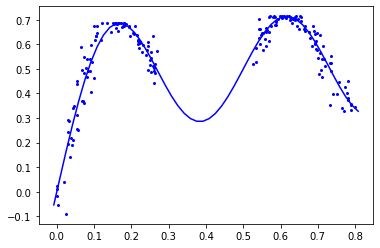

In [153]:
from training import toy

torch.manual_seed(42)

trainset = toy.TrigonometricToyDataset(sample_count=200, noise=0.02, normalize=False, max=0.8, skip=0.25)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

trainset.plot_dataset()

In [138]:
torch.manual_seed(42)
gp = exp.gaussian_process(100, trainset.normalized_xs, trainset.normalized_ys)

Epoch 0: loss 0.7717236280441284
Epoch 20: loss -0.03826034441590309
Epoch 40: loss -0.9466961026191711
Epoch 60: loss -1.4638110399246216
Epoch 80: loss -1.4640426635742188


In [156]:
torch.manual_seed(42)
pp = exp.point_estimator(layers, noise, learn_var, 900, trainloader, batch_size, device)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 0: loss -0.019352035596966743
Epoch 100: loss -0.06830703467130661
Epoch 200: loss -0.08435721695423126
Epoch 300: loss -0.08422008156776428
Epoch 400: loss -0.08660231530666351
Epoch 500: loss -0.08756429702043533
Epoch 600: loss -0.08791010081768036
Epoch 700: loss -0.08910311758518219
Epoch 800: loss -0.09187067300081253
Final loss -0.09304627776145935


In [190]:
torch.manual_seed(42)
swag = exp.swag(layers, noise, learn_var, 900, 5, 20, trainloader, batch_size)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 0: loss -0.019352035596966743
Epoch 100: loss -0.06830703467130661
Epoch 200: loss -0.08435721695423126
Epoch 300: loss -0.08422008156776428
Epoch 400: loss -0.08660231530666351
Epoch 500: loss -0.08756429702043533
Epoch 600: loss -0.08791010081768036
Epoch 700: loss -0.08910311758518219
Epoch 800: loss -0.09187067300081253
Final loss -0.09304627776145935


In [191]:
torch.manual_seed(42)
ensemble = exp.ensemble(5, layers, noise, learn_var, 900, trainloader, batch_size, parallel=False)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1)

In [197]:
torch.manual_seed(42)
mc_dropout = exp.mc_dropout(0.1, layers, noise, learn_var, 900, trainloader, batch_size)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=35, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=35, out_features=35, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=35, out_features=35, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=35, out_features=1, bias=True)
)
Epoch 0: loss -0.04623353108763695
Epoch 100: loss -0.08249913901090622
Epoch 200: loss -0.08788342773914337
Epoch 300: loss -0.08822451531887054
Epoch 400: loss -0.09039641171693802
Epoch 500: loss -0.08920774608850479
Epoch 600: loss -0.08926518261432648
Epoch 700: loss -0.09027083218097687
Epoch 800: loss -0.0911581963300705
Final loss -0.09162870049476624


In [206]:
torch.manual_seed(42)
intel_bbb = exp.intel_bbb(layers, noise, learn_var, 1000, trainloader, batch_size)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 0: loss 0.06866757571697235
Epoch 100: loss -0.048758093267679214
Epoch 200: loss -0.05755787715315819
Epoch 300: loss -0.06361066550016403
Epoch 400: loss -0.0662316381931305
Epoch 500: loss -0.06049864739179611
Epoch 600: loss 0.057185955345630646
Epoch 700: loss -0.04823724180459976
Epoch 800: loss -0.04343046993017197
Epoch 900: loss -0.047489847987890244
Final loss -0.04518352448940277


In [222]:
torch.manual_seed(42)
bbb = exp.bbb(layers, noise, learn_var, 10000, trainloader, batch_size, device)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
  (3): ReLU()
  (4): BBBLinear()
  (5): ReLU()
  (6): BBBLinear()
)
Epoch 0: loss 4.490897178649902
Epoch 100: loss 0.04744921624660492
Epoch 200: loss 0.01623592898249626
Epoch 300: loss 0.008772299624979496
Epoch 400: loss -0.007575377356261015
Epoch 500: loss -0.01366129145026207
Epoch 600: loss -0.024107377976179123
Epoch 700: loss -0.019184015691280365
Epoch 800: loss -0.024258043617010117
Epoch 900: loss -0.02836834266781807
Epoch 1000: loss -0.029606247320771217
Epoch 1100: loss -0.02739144116640091
Epoch 1200: loss -0.03663751482963562
Epoch 1300: loss -0.02645486406981945
Epoch 1400: loss -0.028648478910326958
Epoch 1500: loss -0.034719791263341904
Epoch 1600: loss -0.031733714044094086
Epoch 1700: loss -0.03155273571610451
Epoch 1800: loss -0.029057888314127922
Epoch 1900: loss -0.024289708584547043
Epoch 2000: loss -0.028597721830010414
Epoch 2100: loss -0.026199031621217728
Epoch 2200: loss -0.

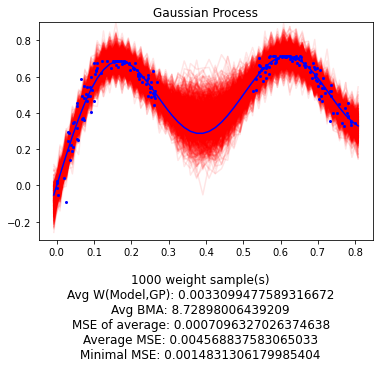

In [214]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.1, samples=1000)

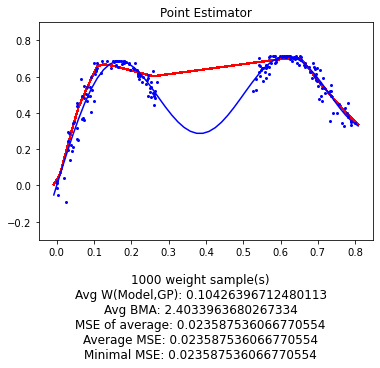

In [215]:
trainset.plot("Point Estimator", pp, gp, alpha=0.1, samples=1000)

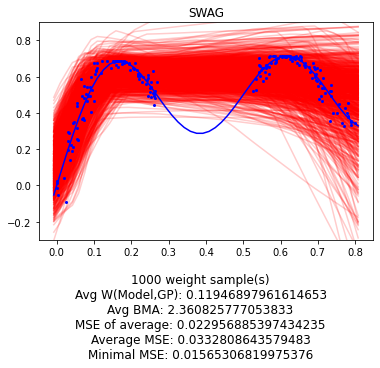

In [216]:
trainset.plot("SWAG", swag, gp, alpha=0.2, samples=1000)

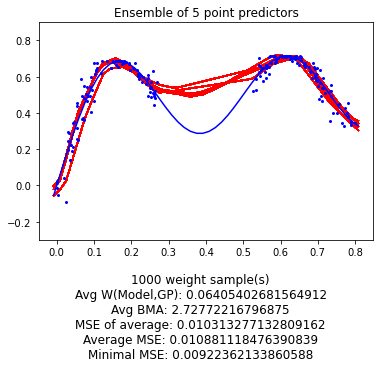

In [217]:
trainset.plot("Ensemble of 5 point predictors", ensemble, gp, alpha=0.1, samples=1000)

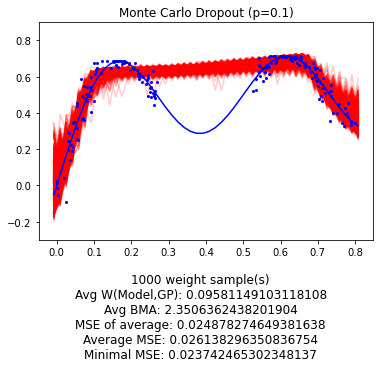

In [218]:
trainset.plot("Monte Carlo Dropout (p=0.1)", mc_dropout, gp, alpha=0.2, samples=1000)

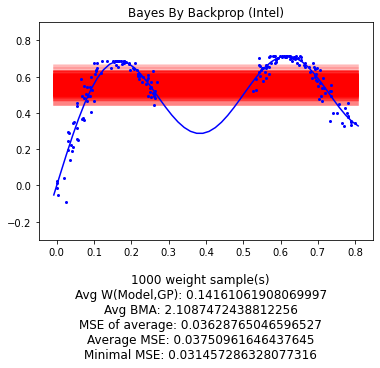

In [219]:
trainset.plot("Bayes By Backprop (Intel)", intel_bbb, gp, alpha=0.2, samples=1000)

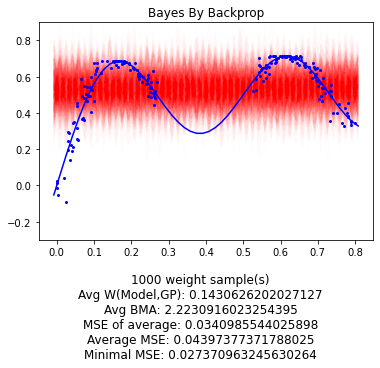

In [223]:
trainset.plot("Bayes By Backprop", bbb, gp, alpha=0.01, samples=1000)